In [1]:
### Quantum Associative Memory by D. Ventura, T. Martinez
## Importing libraries
%matplotlib inline
import qiskit
from qiskit import IBMQ
from qiskit import Aer
from qiskit import QuantumCircuit, ClassicalRegister,QuantumRegister, QiskitError
from qiskit.tools.visualization import circuit_drawer
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.aer import noise
import random
import matplotlib
import math
from math import *



In [5]:
## Defining some auxiliary functions
def convertToNumEncoding(genome_str):
    bin_str = ""
    for i in range(0, len(genome_str)):
        if genome_str[i] == 'A':
            bin_str = bin_str + "0"
        elif genome_str[i] == 'C':
            bin_str = bin_str + "1"
        elif genome_str[i] == 'G':
            bin_str = bin_str + "2"
        elif genome_str[i] == 'T':
            bin_str = bin_str + "3"
    return bin_str
    

In [8]:
## Initializing global variables
# Alphabet set (0, 1, 2, 3) := {A, C, G, T} for DNA Nucleotide bases
AS = {'00', '01', '10', '11'}
A = len(AS)
genome_file = open("nsp14.txt", "r")
RG = genome_file.read()
genome_file.close()
RG = convertToNumEncoding(RG)
RG = RG[0:32]
N = len(RG)

In [10]:
# Short Read search string
SR = "2?3"
M = len(SR)
Q_A = ceil(log2(A))
# Data Qubits
Q_D = Q_A * M
# Tag Qubits
Q_T = ceil(log2(N - M + 1))
# Ancilla Qubits
Q_anc = 8
# Ancilla qubits ids
anc = []
for qi in range(0, Q_anc):
    anc.append(Q_D + Q_T + qi)
# Total number of qubits
Q = Q_D + Q_T + Q_anc


In [20]:
IBMQ.save_account('APIKEY', overwrite=True)
## Initialization of IBM QX
IBMQ.enable_account('bf333c31a0a3b9e5829fa0a0e0097216062f044a366ff7cce49dc0f004ad35da0d8067cb98c1f59e8d79704b055dac79de9e88c4e10306dc2cb14e20183f4e68')
provider = IBMQ.get_provider()
# Pick an available backend
# If this isn’t available pick a backend whose name containes ’_qasm_simulator’ from the output above
#backend = provider.get_backend('ibmq_qasm_simulator')


IBMQAccountError: 'An IBM Quantum Experience account is already in use for the session.'

In [23]:
backend = Aer.get_backend('qasm_simulator')

In [26]:
## Defining functions
def QAM():
    print('Reference genome:', RG)
    print('Chosen pattern for testing:', SR)
    print('Total number of qubits:', Q)
    print('Number of ancilla qubits:', Q_anc)
    qr = qiskit.QuantumRegister(Q)
    cr = qiskit.ClassicalRegister(Q_T)
    qc = qiskit.QuantumCircuit(qr, cr)
# Patterns are stored
    generateInitialState(qc, qr)
# Patterns are turned into Hamming Distances
    evolveToHammingDistances(qc, qr)
# Marking the zero Hamming Distance states
    markZeroHammingDistance(qc, qr)
    inversionAboutMean(qc, qr)
# Applying again this funcions turns back the Hamming Distances into the original patterns
    evolveToHammingDistances(qc, qr)
# Marking the stored patterns
    markStoredPatterns(qc, qr)
    # From patterns to Hamming Distances again
    evolveToHammingDistances(qc, qr)
    inversionAboutMean(qc, qr)
# Grover’s iterations
    it = 0
    for i in range(0, 1):
        markZeroHammingDistance(qc, qr)
        inversionAboutMean(qc, qr)
        it = it + 1
    print("Grover’s algorithm had {} iterations.".format(int(it)))
    finalGroverMeasurement(qc, qr, cr)
    return qc



In [27]:
# Initialization as suggested by L. C. L. Hollenberg
def generateInitialState(qc, qr):
    for qi in range(0, Q_T):
        qc.h(qr[qi])
    
    control_qubits = []
    for ci in range(0, Q_T):
        control_qubits.append(qr[ci])
    
    ancilla_qubits = []
    for qi in anc:
        ancilla_qubits.append(qr[qi])
    
    for qi in range(0, N - M + 1):
        qis = format(qi, '0' + str(Q_T) + 'b')
        for qisi in range(0, Q_T):
            if qis[qisi] == '0':
                qc.x(qr[qisi])
        wMi = RG[qi:qi + M]
        print("Tag: {} - Data: {}".format(qis, wMi))
        for wisi in range(0, M):
            wisia = format(int(wMi[wisi]), '0' + str(Q_A) + 'b')
            for wisiai in range(0, Q_A):
                if wisia[wisiai] == '1':
                    qc.mct(control_qubits, qr[Q_T + wisi * Q_A + wisiai], ancilla_qubits)
        for qisi in range(0,Q_T):
            if qis[qisi] == '0':
                qc.x(qr[qisi])
    return


In [29]:
def evolveToHammingDistances(qc, qr):
    for pi in range(0, M):
        if SR[pi] == '?':
            continue
        ppi = format(int(SR[pi]), '0' + str(Q_A) + 'b')
        for ppii in range(0, Q_A):
            if ppi[ppii] == '1':
                qc.x(qr[Q_T + pi * Q_A + ppii])
    return


In [30]:
# Oracle to mark zero Hamming Distance
def markZeroHammingDistance(qc, qr):
    for qi in range(0, Q_D):
        qc.x(qr[Q_T + qi])
    control_qubits = []
    for mi in range(0, M):
        if SR[mi] != '?':
            for ai in range(0, Q_A):
                control_qubits.append(qr[Q_T + mi * Q_A + ai])
    
    ancilla_qubits = []
    for qi in anc:
        ancilla_qubits.append(qr[qi])
    target = control_qubits.pop()
    qc.h(target)
    qc.mct(control_qubits, target, ancilla_qubits)
    qc.h(target)
    for qi in range(0, Q_D):
        qc.x(qr[Q_T + qi])
    return


In [31]:
# Inversion about mean
def inversionAboutMean(qc, qr):
    for si in range(0, Q_D + Q_T):
        qc.h(qr[si])
        qc.x(qr[si])
    
    control_qubits = []
    for qi in range(1, Q_D + Q_T):
        control_qubits.append(qr[qi])
    
    ancilla_qubits = []
    for qi in anc:
        ancilla_qubits.append(qr[qi])
    qc.h(qr[0])
    qc.mct(control_qubits, qr[0], ancilla_qubits)
    qc.h(qr[0])
    for si in range(0, Q_D + Q_T):
        qc.x(qr[si])
        qc.h(qr[si])
    return



In [32]:
# Oracle to mark stored patterns
def markStoredPatterns(qc, qr):
    control_qubits = []
    for qi in range(1, Q_D + Q_T):
        control_qubits.append(qr[qi])
    
    ancilla_qubits = []
    for qi in anc:
        ancilla_qubits.append(qr[qi])
   
    for qi in range(0, N - M + 1):
        qis = format(qi, '0' + str(Q_T) + 'b')
        for qisi in range(0, Q_T):
            if qis[qisi] == '0':
                qc.x(qr[qisi])
        wMi = RG[qi:qi + M]
        for wisi in range(0, M):
            wisia = format(int(wMi[wisi]), '0' + str(Q_A) + 'b')
            for wisiai in range(0, Q_A):
                if wisia[wisiai] == '0':
                    qc.x(qr[Q_T + wisi * Q_A + wisiai])
        qc.h(qr[0])
        qc.mct(control_qubits, qr[0], ancilla_qubits)
        qc.h(qr[0])
        for wisi in range(0,M):
            wisia = format(int(wMi[wisi]), '0' + str(Q_A) + 'b')
            for wisiai in range(0, Q_A):
                if wisia[wisiai] == '0':
                    qc.x(qr[Q_T + wisi * Q_A + wisiai])
        for qisi in range(0, Q_T):
            if qis[qisi] == '0':
                qc.x(qr[qisi])
    return

In [33]:
# Final measurement
def finalGroverMeasurement(qc, qr, cr):
    for qi in range(0, Q_T):
        qc.measure(qr[qi], cr[qi])
    return

In [34]:
## Main function
if __name__ == '__main__':
# Printing some data for testing
    qc = QAM()
    print("Circuit depth: {}".format(qc.depth()))
# Total number of gates
    print("Number of gates: {}".format(len(qc.data)))
    gate_num = 1
    for item in qc.data:
        qb_list = ""
        for qb in item[1]:
            qb_list = qb_list + str(qb.index) + ", "
        qb_list = qb_list[:len(qb_list)-2]
        print("#{}: {}, {}".format(gate_num, item[0].name, qb_list))
        gate_num = gate_num + 1


Reference genome: 02132000032300102201313330002033
Chosen pattern for testing: 2?3
Total number of qubits: 19
Number of ancilla qubits: 8
Tag: 00000 - Data: 021
Tag: 00001 - Data: 213
Tag: 00010 - Data: 132
Tag: 00011 - Data: 320
Tag: 00100 - Data: 200
Tag: 00101 - Data: 000
Tag: 00110 - Data: 000
Tag: 00111 - Data: 003
Tag: 01000 - Data: 032
Tag: 01001 - Data: 323
Tag: 01010 - Data: 230
Tag: 01011 - Data: 300
Tag: 01100 - Data: 001
Tag: 01101 - Data: 010
Tag: 01110 - Data: 102
Tag: 01111 - Data: 022
Tag: 10000 - Data: 220
Tag: 10001 - Data: 201
Tag: 10010 - Data: 013
Tag: 10011 - Data: 131
Tag: 10100 - Data: 313
Tag: 10101 - Data: 133
Tag: 10110 - Data: 333
Tag: 10111 - Data: 330
Tag: 11000 - Data: 300
Tag: 11001 - Data: 000
Tag: 11010 - Data: 002
Tag: 11011 - Data: 020
Tag: 11100 - Data: 203
Tag: 11101 - Data: 033
Grover’s algorithm had 1 iterations.
Circuit depth: 286
Number of gates: 879
#1: h, 0
#2: h, 1
#3: h, 2
#4: h, 3
#5: h, 4
#6: x, 0
#7: x, 1
#8: x, 2
#9: x, 3
#10: x, 4
#11:

In [35]:
# Drawing circuit
qc.draw()


┌───┐┌───┐          ┌───┐┌───┐                    ┌───┐┌───┐          »
 q0_0: ┤ H ├┤ X ├──■────■──┤ X ├┤ X ├──■────■────■────■──┤ X ├┤ X ├──■────■──»
       ├───┤├───┤  │    │  ├───┤├───┤  │    │    │    │  ├───┤├───┤  │    │  »
 q0_1: ┤ H ├┤ X ├──■────■──┤ X ├┤ X ├──■────■────■────■──┤ X ├┤ X ├──■────■──»
       ├───┤├───┤  │    │  ├───┤├───┤  │    │    │    │  ├───┤├───┤  │    │  »
 q0_2: ┤ H ├┤ X ├──■────■──┤ X ├┤ X ├──■────■────■────■──┤ X ├┤ X ├──■────■──»
       ├───┤├───┤  │    │  ├───┤├───┤  │    │    │    │  ├───┤└───┘  │    │  »
 q0_3: ┤ H ├┤ X ├──■────■──┤ X ├┤ X ├──■────■────■────■──┤ X ├───────■────■──»
       ├───┤├───┤  │    │  ├───┤└───┘  │    │    │    │  ├───┤       │    │  »
 q0_4: ┤ H ├┤ X ├──■────■──┤ X ├───────■────■────■────■──┤ X ├───────■────■──»
       └───┘└───┘  │    │  └───┘     ┌─┴─┐  │    │    │  └───┘       │    │  »
 q0_5: ────────────┼────┼────────────┤ X ├──┼────┼────┼──────────────┼────┼──»
                   │    │            └───┘  │    │    │            ┌─┴─┐  │  »
 q0_6: ────────────┼────┼───────────────────┼────┼────┼────────────┤ X ├──┼──»
                 ┌─┴─┐  │                   │    │    │            └───┘┌─┴─┐»
 q0_7: ──────────┤ X ├──┼───────────────────┼────┼────┼─────────────────┤ X ├»
                 └───┘  │                 ┌─┴─┐  │    │                 └───┘»
 q0_8: ─────────────────┼─────────────────┤ X ├──┼────┼──────────────────────»
                        │                 └───┘┌─┴─┐  │                      »
 q0_9: ─────────────────┼──────────────────────┤ X ├──┼──────────────────────»
                      ┌─┴─┐                    └───┘┌─┴─┐                    »
q0_10: ───────────────┤ X ├─────────────────────────┤ X ├────────────────────»
                      └───┘                         └───┘                    »
q0_11: ──────────────────────────────────────────────────────────────────────»
                                                                             »
q0_12: ──────────────────────────────────────────────────────────────────────»
                                                                             »
q0_13: ──────────────────────────────────────────────────────────────────────»
                                                                             »
q0_14: ──────────────────────────────────────────────────────────────────────»
                                                                             »
q0_15: ──────────────────────────────────────────────────────────────────────»
                                                                             »
q0_16: ──────────────────────────────────────────────────────────────────────»
                                                                             »
q0_17: ──────────────────────────────────────────────────────────────────────»
                                                                             »
q0_18: ──────────────────────────────────────────────────────────────────────»
                                                                             »
 c0: 5/══════════════════════════════════════════════════════════════════════»
                                                                             »
«                 ┌───┐┌───┐               ┌───┐┌───┐     ┌───┐┌───┐┌───┐┌───┐»
« q0_0: ──■────■──┤ X ├┤ X ├──■────■────■──┤ X ├┤ X ├──■──┤ X ├┤ X ├┤ X ├┤ X ├»
«         │    │  ├───┤├───┤  │    │    │  ├───┤├───┤  │  ├───┤├───┤├───┤├───┤»
« q0_1: ──■────■──┤ X ├┤ X ├──■────■────■──┤ X ├┤ X ├──■──┤ X ├┤ X ├┤ X ├┤ X ├»
«         │    │  ├───┤├───┤  │    │    │  ├───┤└───┘  │  └───┘└───┘└───┘└───┘»
« q0_2: ──■────■──┤ X ├┤ X ├──■────■────■──┤ X ├───────■──────────────────────»
«         │    │  └───┘└───┘  │    │    │  ├───┤       │  ┌───┐┌───┐┌───┐     »
« q0_3: ──■────■──────────────■────■────■──┤ X ├───────■──┤ X ├┤ X ├┤ X ├─────»
«         │    │  ┌───┐       │    │    │  ├───┤       │  ├───┤├───┤├───┤     »
« q0_4: ──■────■──┤ X ├───────■────■────■──┤ X ├

{'00000': 2429, '00001': 2429, '10000': 3435, '10001': 2487, '10010': 2347, '10011': 2370, '10100': 2418, '10101': 2447, '10110': 2424, '10111': 2354, '11000': 2548, '11001': 2402, '11010': 2501, '11011': 2437, '11100': 2430, '11101': 2394, '11110': 2478, '11111': 2574, '00010': 2472, '00011': 2403, '00100': 2348, '00101': 2448, '00110': 2442, '00111': 3458, '01000': 2431, '01001': 2341, '01010': 2415, '01011': 2418, '01100': 2477, '01101': 2498, '01110': 2517, '01111': 2620}


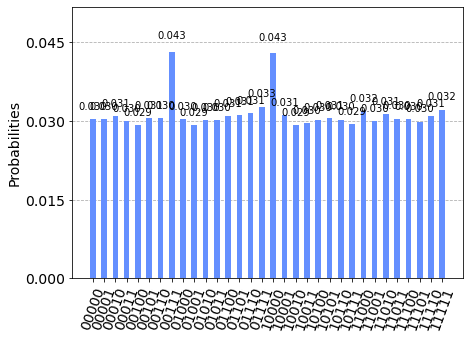

In [39]:
# Qiskit uses a LSB ordering, meaning the first qubit is all the way to the right!
# For example, a state of |01> would mean the first qubit is 1 and the second qubit is 0!
sim = qiskit.execute(qc, backend=backend, shots=80192)
result = sim.result()
final = result.get_counts(qc)
print(final)
plot_histogram(final)
